In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import mlflow
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [10]:
def plot_top_runs(data_type, group_cols):
    tops = None
    top_all = None

    for exp in mlflow.MlflowClient().search_experiments(filter_string=f"name LIKE '{data_type}%'"):
        print(exp.name)
        experiment_id = exp.experiment_id
        runs = mlflow.search_runs(experiment_ids=experiment_id)
        top_level_runs = runs[runs['tags.mlflow.parentRunId'].isnull()].run_id
        second_level_runs = runs[runs['tags.mlflow.parentRunId'].isin(top_level_runs)].copy()
        if 'tags.subregion' not in second_level_runs.columns:
            second_level_runs['tags.subregion'] = 'all'
        if 'tags.phase' not in second_level_runs.columns:
            second_level_runs['tags.phase'] = 'all'
        if 'tags.monkey' not in second_level_runs.columns:
            second_level_runs['tags.monkey'] = 'all'

        top = second_level_runs.groupby(group_cols).apply(lambda x: x.nlargest(5, 'metrics.val_acc', keep='all'), include_groups=False)
        cols = ['metrics.val_acc', 'metrics.test_acc', 'metrics.train_acc', 'run_id', 'tags.n_cells']
        # if 'tags.subregion' in second_level_runs:
        #     cols += ['tags.subregion']
        top = top[cols].reset_index()
        # top['model'] = top["tags.model"].apply(lambda x: f'{monkey} {area} {x}')
        tops = top if tops is None else pd.concat([tops, top])
        top_runs = runs[runs.run_id.isin(top.run_id)].copy()
        # top_runs['model'] = top_runs["tags.model"].apply(lambda x: f'{monkey} {area} {x}')
        top_all = top_runs if top_all is None else pd.concat([top_all, top_runs])

    tops['tags.n_cells'] = tops['tags.n_cells'].astype(int)

    plt.figure(figsize=(10, 7))

    gb = tops.groupby(group_cols)['metrics.test_acc']
    name = [' '.join(i) for i in gb.first().index] #gb.first().index.tolist()
    tmin = gb.min().tolist()
    tmax = gb.max().tolist()
    median = gb.median().tolist()
    n_cells_min = tops.groupby(group_cols)['tags.n_cells'].min()
    n_cells_max = tops.groupby(group_cols)['tags.n_cells'].max()

    gb = tops.groupby(group_cols)['metrics.val_acc']
    val_min = gb.min().tolist()
    val_max = gb.max().tolist()
    val_median = gb.median().tolist()

    gb = tops.groupby(group_cols)['metrics.train_acc']
    train_min = gb.min().tolist()
    train_max = gb.max().tolist()
    train_median = gb.median().tolist()

    for i in range(len(tmin)):
        c = 'red' if 'Logistic' in name[i] else 'green' if 'SVC' in name[i] else 'blue' if 'FNN' in name[i] else 'purple'
        # plt.errorbar(train_median[i], name[i], xerr=[[train_median[i] - train_min[i]], [train_max[i] - train_median[i]]], fmt='|', ecolor='black', color='gray', label=name[i], linestyle='--', linewidth=8, alpha=0.1)
        # plt.errorbar(val_median[i], name[i], xerr=[[val_median[i] - val_min[i]], [val_max[i] - val_median[i]]], fmt='|', ecolor='black', color='gray', label=name[i], linestyle='--', linewidth=4, alpha=0.3)
        plt.errorbar(median[i], name[i], xerr=[[median[i] - tmin[i]], [tmax[i] - median[i]]], fmt='o', ecolor=c, color=c, label=name[i])

    group_cols_wo_model = group_cols.copy()
    group_cols_wo_model.remove('tags.model')
    gb = tops.groupby(group_cols_wo_model)
    name = [' '.join(i) for i in gb.first().index]
    n_cells_min = gb['tags.n_cells'].min()
    n_cells_max = gb['tags.n_cells'].max()

    plt.legend(['FNN', 'KNN', 'LR', 'SVC'])
    # name = [n.rsplit(' ', 1)[0] for n in name]
    name = [f'{n} (n={nc_min}-{nc_max})' for n, nc_min, nc_max in zip(name, n_cells_min, n_cells_max)]
    # plt.yticks(np.arange(1, len(name), 3), name[::3])
    plt.yticks(np.arange(1, len(name) * 4, 4), name)
    plt.xlabel('Test Accuracy')

    for i in range(0, len(name) * 4 + 1, 4):
        plt.axhline(i - 0.5, color='gray', linestyle='--', linewidth=0.5)

    plt.title(data_type)

msng-LEM-PPC-LIP
msng-KEN-PPC-LIP
msng-LEM-PPC-7a
msng-KEN-PPC-7a
msng-LEM-PPC-None
msng-KEN-PPC-None
msng-LEM-PFC-None
msng-KEN-PFC-None
msng-None-PPC-LIP
msng-None-PPC-7a
msng-None-PFC-8
msng-None-PFC-46
msng-None-PPC-None
msng-None-PFC-None


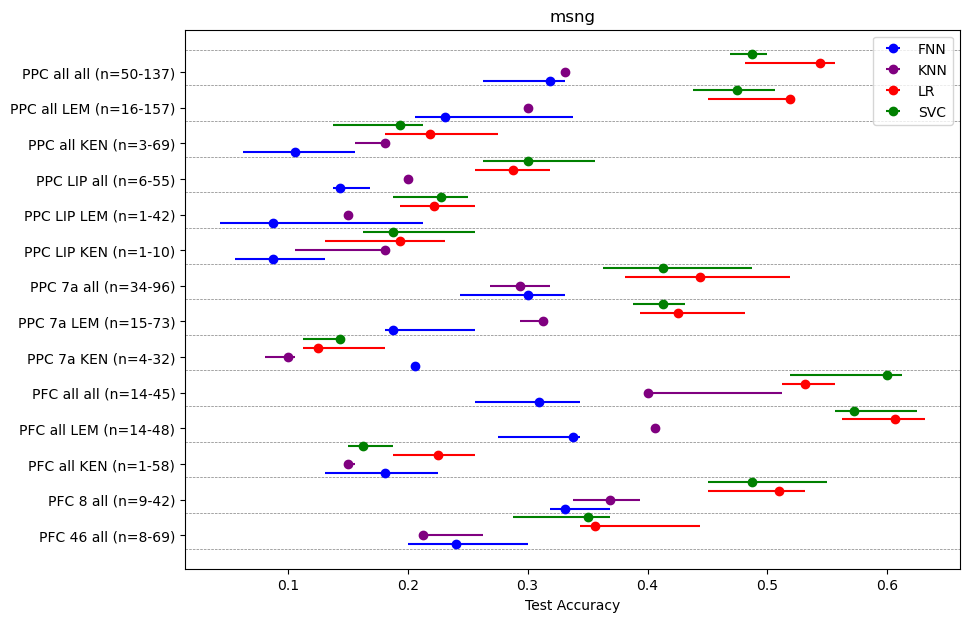

In [11]:
# data_type = 'mnm_feature'
# group_cols = ['tags.phase', 'tags.subregion', 'tags.monkey', 'tags.model']
# data_type = 'msng'
# group_cols = ['tags.area', 'tags.subregion', 'tags.monkey', 'tags.model']
plot_top_runs('msng', ['tags.area', 'tags.subregion', 'tags.monkey', 'tags.model'])

mnm_feature-MAN-PFC-AD-PRE
mnm_feature-ELV-PFC-PV-POST
mnm_feature-ELV-PFC-PV-PRE
mnm_feature-ELV-PFC-MD-POST
mnm_feature-ELV-PFC-MD-PRE
mnm_feature-BEN-PFC-MD-PRE
mnm_feature-None-PFC-PD-POST
mnm_feature-None-PFC-AD-PRE
mnm_feature-None-PFC-PV-POST
mnm_feature-None-PFC-PV-PRE
mnm_feature-None-PFC-MD-POST
mnm_feature-None-PFC-MD-PRE
mnm_feature-None-PFC-None-POST
mnm_feature-None-PFC-None-PRE


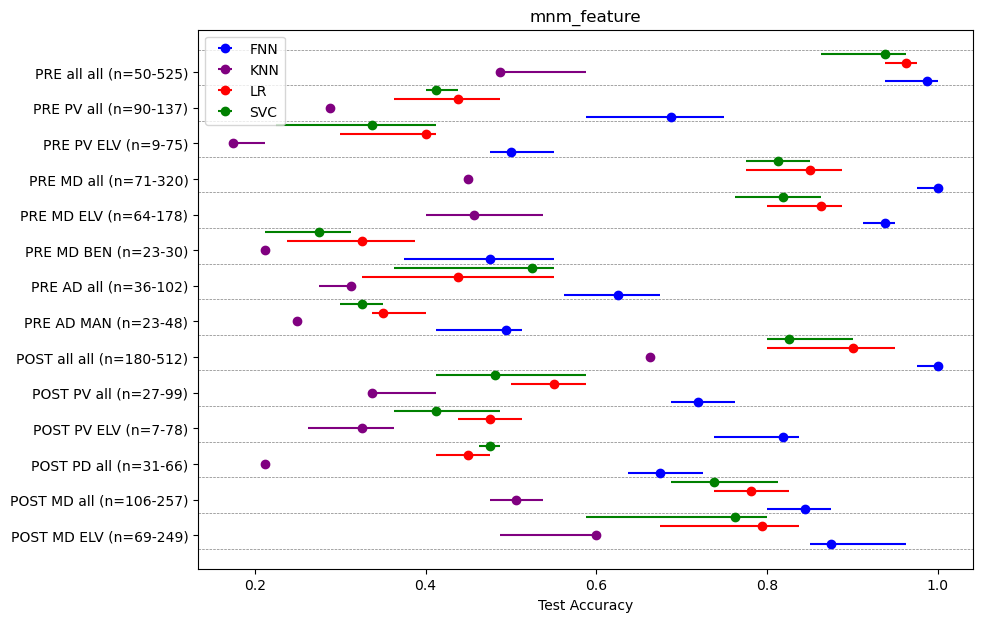

In [12]:
plot_top_runs('mnm_feature', ['tags.phase', 'tags.subregion', 'tags.monkey', 'tags.model'])

mnm_spatial-BEN-PFC-MD-PRE
mnm_spatial-NIN-PFC-AD-PRE
mnm_spatial-ADR-PFC-PD-POST
mnm_spatial-ELV-PFC-PV-POST
mnm_spatial-ELV-PFC-MD-POST
mnm_spatial-ELV-PFC-MD-PRE
mnm_spatial-None-PFC-AD-POST
mnm_spatial-None-PFC-PV-POST
mnm_spatial-None-PFC-PV-PRE
mnm_spatial-None-PFC-PD-POST
mnm_spatial-None-PFC-PD-PRE
mnm_spatial-None-PFC-MD-POST
mnm_spatial-None-PFC-MD-PRE
mnm_spatial-None-PFC-None-POST
mnm_spatial-None-PFC-None-PRE


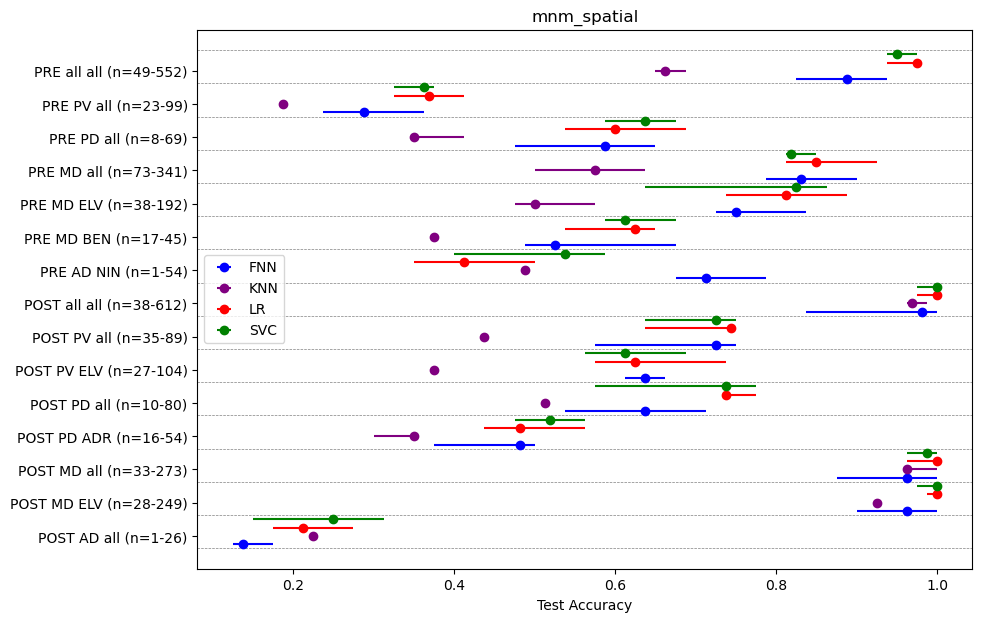

In [14]:
plot_top_runs('mnm_spatial', ['tags.phase', 'tags.subregion', 'tags.monkey', 'tags.model'])

odr-ELV-PPC
odr-LEM-PPC
odr-KEN-PPC
odr-ELV-PFC
odr-LEM-PFC
odr-KEN-PFC
odr-YOUNG-PFC


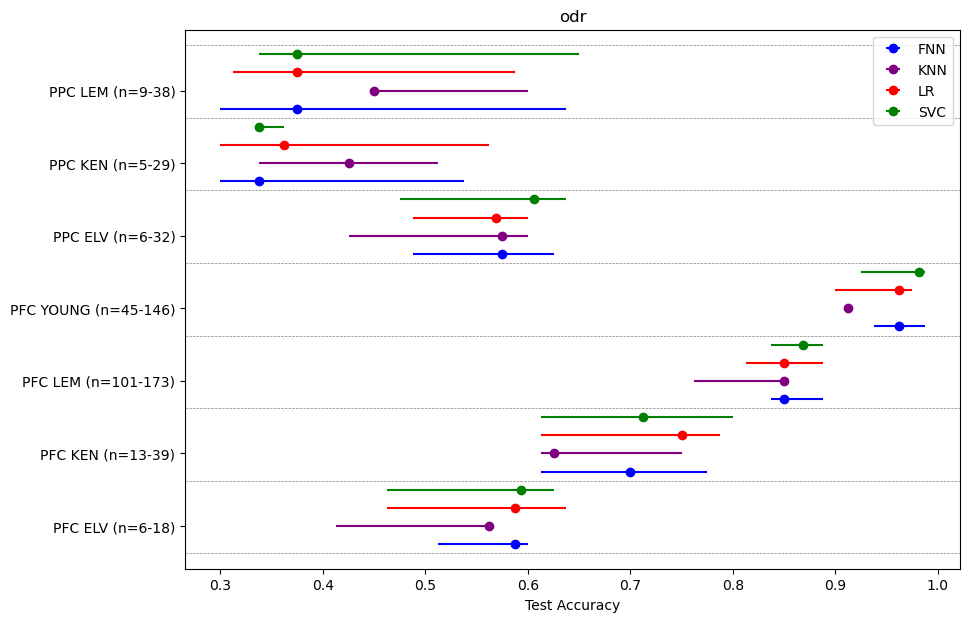

In [15]:
plot_top_runs('odr', ['tags.area', 'tags.monkey', 'tags.model'])